In [85]:
#Next daily price close predictions - Predict the target using different arguments
#Model Type - Artificial Neural Network 
#09-09-2022
#Version - V1.2 

#Goals:
#To predict the next daily close using an Artificial Neural Network 


#Version Implementations:
#Added Market chart fo the whole interval 
#Added Market chart for the Test timeframe 
#Added Yearly and monthly P/L calculations 
#Added Relatory with results 

#Future Implements 
#Plot Return charts to identify the variables that work 
#Plot Comparison to random parameters 
#Plot Price x Return Chart at the same chart 
#Add buy and hold prices for comparison


#Author - Luiz Gabriel Bongiolo

#Credits & References 
#Leandro Guerra Outspoken Market - Check him at: www.outspokenmarket.com / instagram @leandrowar,  




In [86]:
# Load libraries

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime
import pandas_datareader as pdr
import pickle

In [87]:
# Remove Warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

______________________________________________________

In [88]:
#Import data

ticker = "BTC-USD"
start = "2017-12-18"
end = datetime.datetime.now()

df1 = pdr.get_data_yahoo(ticker, start, end)
#df1.reset_index(inplace=True)

df1.drop(["Volume", "Adj Close"], axis=1, inplace=True)

df1

,High,Low,Open,Close
Date,,,,
2017-12-18,19371.000000,18355.900391,19106.400391,19114.199219
2017-12-19,19177.800781,17275.400391,19118.300781,17776.699219
2017-12-20,17934.699219,16077.700195,17760.300781,16624.599609
2017-12-21,17567.699219,15342.700195,16642.400391,15802.900391
2017-12-22,15943.400391,11833.000000,15898.000000,13831.799805
...,...,...,...,...
2022-10-11,19241.960938,18925.603516,19139.000000,19051.417969
2022-10-12,19203.199219,19029.757812,19052.646484,19157.445312
2022-10-13,19453.328125,18319.822266,19156.966797,19382.904297


______________________________________________________

In [89]:
df1.describe()

,High,Low,Open,Close
count,1763.000000,1763.000000,1763.000000,1763.000000
mean,20924.557024,19826.300146,20412.006484,20409.424411
std,17736.267297,16765.600828,17286.609162,17282.004665
min,3275.377930,3191.303467,3236.274658,3236.761719
25%,7721.421387,7403.937744,7556.229492,7557.028809
50%,10916.053711,10352.700195,10669.371094,10669.583008
75%,35998.525391,33413.777344,34672.343750,34665.492188
max,68789.625000,66382.062500,67549.734375,67566.828125


______________________________________________________

In [90]:
# Building the targets

periods = 1

# lag of X periods
df1["Lag1"] = df1["Close"].shift(-periods)

# Target 1 - Return
df1["Return"] = df1["Close"].pct_change(periods)
df1["Target1"] = df1["Return"].shift(-periods)

# Target Points Variation
df1["Points"] = (df1["Close"] - df1["Close"].shift(1))
df1["Points"] = df1["Points"].shift(-periods)

In [91]:
df1["Return"].describe()

count    1762.000000
mean        0.000786
std         0.039292
min        -0.371695
25%        -0.016174
50%         0.001080
75%         0.017665
max         0.187465
Name: Return, dtype: float64

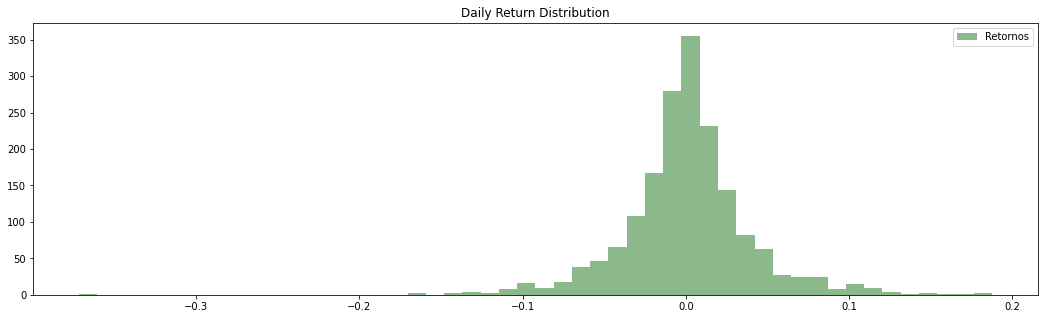

In [92]:
plt.figure(figsize = (18,5))
plt.hist(df1["Return"], bins = 50
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Daily Return Distribution");

In [93]:
# Creating the target
df1["Target_Bin"] = np.where(df1['Target1'] > df1["Return"].describe()[6]/2 , 1
                           , np.where(df1['Target1'] < df1["Return"].describe()[4]/2, -1, 0))

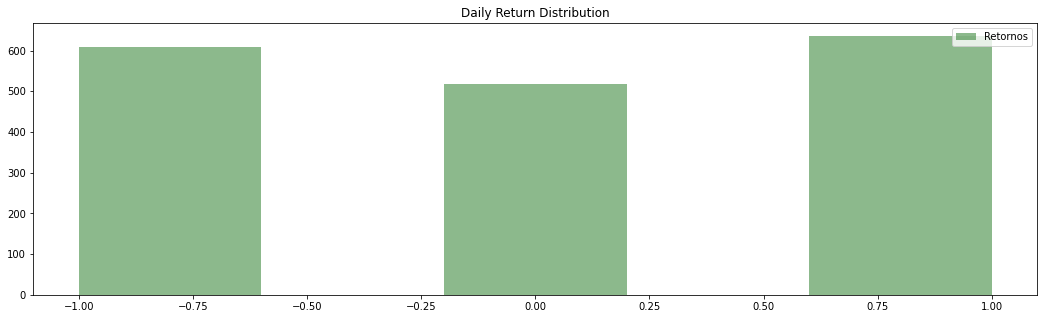

In [94]:
plt.figure(figsize = (18,5))
plt.hist(df1["Target_Bin"], bins = 5
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Daily Return Distribution");

In [95]:
# Building the variables that will be used to teach the model 

# 5 days standard deviation
df1["std5"] = df1["Return"].rolling(5).std()

# 10 days standard deviation
df1["std10"] = df1["Return"].rolling(10).std()

# 15 days standard deviation
df1["std15"] = df1["Return"].rolling(15).std()

# Proportion of the candlestick body in relation to the range of the day
df1["prop"] = (df1["Close"]-df1["Open"])/(df1["High"]-df1["Low"])

# Current day direction
df1["dir_D"] = np.where(df1['Close'] > df1['Open'] , '1', '0')

# Direction D-1
df1["dir_D-1"] = df1["dir_D"].shift(1)

# Direction D-2
df1["dir_D-2"] = df1["dir_D"].shift(2)

# Direction D-3
df1["dir_D-3"] = df1["dir_D"].shift(3)

# 15 days moving average of std5
df1["mm_std5"] = df1["std5"].rolling(15).mean()

# 15 days moving average of std10
df1["mm_std10"] = df1["std10"].rolling(15).mean()

# 15 days moving average of std15
df1["mm_std15"] = df1["std15"].rolling(15).mean()

# RSL std5
df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1   #RSL indicator takes the distance from the price (in this case to the moving average)

# RSL std10
df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

# RSL std15
df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

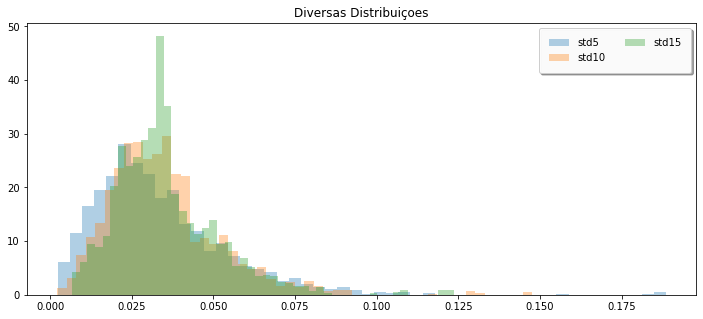

In [96]:
plt.figure(figsize = (12,5))
config = dict(histtype = 'stepfilled', alpha = 0.35, density = True, bins = 50)

plt.hist(df1["std5"], **config, label = "std5")
plt.hist(df1["std10"], **config, label = "std10")
plt.hist(df1["std15"], **config, label = "std15")

#Chart Legends
plt.legend(loc = "upper right"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1)
plt.title("Diversas Distribuiçoes");

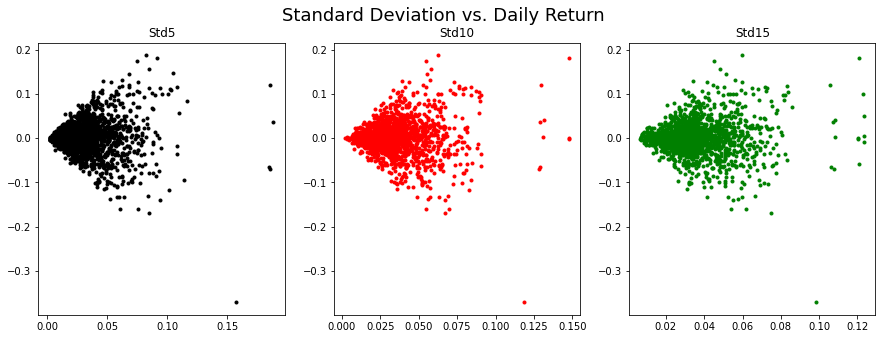

In [97]:
fig, axs = plt.subplots(1,3,figsize=(15, 5));
fig.suptitle("Standard Deviation vs. Daily Return", fontsize = 18);
axs[0].set_title('Std5')
axs[1].set_title('Std10')
axs[2].set_title('Std15')
axs[0].plot(df1["std5"], df1["Return"], ".", color = "black", label = "Random")
axs[1].plot(df1["std10"], df1["Return"], ".", color = "red", label = "Random")
axs[2].plot(df1["std15"], df1["Return"], ".", color = "green", label = "Random");

In [98]:
#This will help the model to understand better the difference between 0 and 1

In [99]:
pd.crosstab(pd.qcut(df1["RSL_std5"], 10, labels = False), df1["Target_Bin"])/df1.shape[0]*100

Target_Bin,-1,0,1
RSL_std5,,,
0.0,3.346568,3.403290,3.176404
1.0,3.516733,2.949518,3.403290
2.0,3.006239,2.836075,4.027226
3.0,4.140669,2.836075,2.949518
4.0,2.949518,3.119682,3.800340
5.0,2.892796,2.495746,4.480998
6.0,4.480998,2.495746,2.949518
7.0,3.006239,2.949518,3.913783
8.0,3.119682,3.176404,3.573454


In [100]:
# Filtering the missing values 

df1_filtered = df1.dropna(axis = 0) 

df1_filtered= df1_filtered.drop(["std5","std10","std15","mm_std5","mm_std10","mm_std15"], axis = 1) #Delete this information because it is already in the RSL

In [101]:
df1_filtered["RSL_std5"] = pd.qcut(df1_filtered["RSL_std5"], 10, labels = False)
df1_filtered["RSL_std10"] = pd.qcut(df1_filtered["RSL_std10"], 10, labels = False)
df1_filtered["RSL_std15"] = pd.qcut(df1_filtered["RSL_std15"], 10, labels = False)

In [102]:
df1_filtered.head()

,High,Low,Open,Close,Lag1,Return,Target1,Points,Target_Bin,prop,dir_D,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15
Date,,,,,,,,,,,,,,,,,
2018-01-16,13843.099609,10194.900391,13836.099609,11490.500000,11188.599609,-0.168548,-0.026274,-301.900391,-1,-0.642947,0,1,0,1,7,4,5
2018-01-17,11678.000000,9402.290039,11431.099609,11188.599609,11474.900391,-0.026274,0.025589,286.300781,1,-0.106560,0,0,1,0,6,4,4
2018-01-18,12107.299805,10942.500000,11198.799805,11474.900391,11607.400391,0.025589,0.011547,132.500000,1,0.237037,1,0,0,1,7,5,4
2018-01-19,11992.799805,11172.099609,11429.799805,11607.400391,12899.200195,0.011547,0.111291,1291.799805,1,0.216401,1,1,0,0,7,5,4
2018-01-20,13103.000000,11656.200195,11656.200195,12899.200195,11600.099609,0.111291,-0.100712,-1299.100586,-1,0.859138,1,1,1,0,8,7,4


______________________________________________________

In [103]:
# Splitting data between training and testing

# Train
start_train = start
end_train = "2021-1-01"

# Test
start_test = "2021-01-02"
end_test = datetime.datetime.now()

df1_train1 = df1_filtered[start_train : end_train]

df1_test1 = df1_filtered[start_test : end_test]

In [104]:
df1_filtered.columns

Index(['High', 'Low', 'Open', 'Close', 'Lag1', 'Return', 'Target1', 'Points',
       'Target_Bin', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2', 'dir_D-3',
       'RSL_std5', 'RSL_std10', 'RSL_std15'],
      dtype='object')

In [105]:
# Train Test Split
 
x_train1 = df1_train1.iloc[:, 9:16]
y_train1 = df1_train1['Target_Bin'].values.reshape(-1, 1)

x_test1 = df1_test1.iloc[:, 9:16]
y_test1 = df1_test1['Target_Bin'].values.reshape(-1, 1)

______________________________________________________

In [106]:
# Training the model - Time to fry

mlp1 = MLPClassifier(hidden_layer_sizes = (100,500,100), max_iter = 500,
                    solver = "sgd", verbose = 10, tol = 1e-8, random_state = 42,
                    learning_rate_init = .00005, learning_rate = "adaptive", activation = "tanh")

mlp1.fit(x_train1, y_train1)

Iteration 1, loss = 1.30071181
Iteration 2, loss = 1.28117674
Iteration 3, loss = 1.25475326
Iteration 4, loss = 1.22763628
Iteration 5, loss = 1.20283698
Iteration 6, loss = 1.18136654
Iteration 7, loss = 1.16336005
Iteration 8, loss = 1.14883502
Iteration 9, loss = 1.13776468
Iteration 10, loss = 1.12851693
Iteration 11, loss = 1.12123560
Iteration 12, loss = 1.11666677
Iteration 13, loss = 1.11293237
Iteration 14, loss = 1.11012064
Iteration 15, loss = 1.10802639
Iteration 16, loss = 1.10657590
Iteration 17, loss = 1.10541212
Iteration 18, loss = 1.10445338
Iteration 19, loss = 1.10397775
Iteration 20, loss = 1.10332451
Iteration 21, loss = 1.10300583
Iteration 22, loss = 1.10267456
Iteration 23, loss = 1.10240906
Iteration 24, loss = 1.10213693
Iteration 25, loss = 1.10203494
Iteration 26, loss = 1.10182021
Iteration 27, loss = 1.10166494
Iteration 28, loss = 1.10154592
Iteration 29, loss = 1.10135815
Iteration 30, loss = 1.10120994
Iteration 31, loss = 1.10105992
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 500, 100),
              learning_rate='adaptive', learning_rate_init=5e-05, max_iter=500,
              random_state=42, solver='sgd', tol=1e-08, verbose=10)

In [107]:
#(100, 500, 100), max_iter = 500,

In [108]:
#Train test predictions

y_pred_train1 = mlp1.predict(x_train1)
y_pred_test1 = mlp1.predict(x_test1)

______________________________________________________

In [109]:
#Training Confusion Matrix

print(confusion_matrix(y_train1, y_pred_train1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_train1, y_pred_train1))

[[ 43  57 240]
 [ 34  84 229]
 [ 30  59 306]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.40      0.13      0.19       340
           0       0.42      0.24      0.31       347
           1       0.39      0.77      0.52       395

    accuracy                           0.40      1082
   macro avg       0.41      0.38      0.34      1082
weighted avg       0.41      0.40      0.35      1082



In [110]:
#Test Confusion Matrix

print(confusion_matrix(y_test1, y_pred_test1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test1, y_pred_test1))

[[ 23  42 188]
 [ 12  24 131]
 [ 22  39 170]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.40      0.09      0.15       253
           0       0.23      0.14      0.18       167
           1       0.35      0.74      0.47       231

    accuracy                           0.33       651
   macro avg       0.33      0.32      0.27       651
weighted avg       0.34      0.33      0.27       651



In [111]:
#Predicting the perfomance for the whole database

y_pred_all = mlp1.predict(df1_filtered.iloc[:, 9:16])

In [112]:
df1_filtered.loc[: , "Predicted"] = y_pred_all
df1_filtered.loc[: , "Model_return"] = df1_filtered.loc[: , "Predicted"]*df1_filtered["Target1"]

#Adding a Stop Loss of X% to the math

stop = 0.01
df1_filtered.loc[: , "Model_return"] = np.where(df1_filtered.loc[: , 'Model_return'] < -stop  #Esse stop nao considera o tick a tick (se bater o stop e voltar a subir) 
                                               , -stop, df1_filtered.loc[: , 'Model_return'])

df1_filtered.loc[: , "Model_return_Accumulated"] = df1_filtered["Model_return"].cumsum()

In [113]:
df1_filtered.loc[: , "Model_return_Accumulated"].tail()

Date
2022-10-10    15.26407
2022-10-11    15.26407
2022-10-12    15.26407
2022-10-13    15.26407
2022-10-14    15.26284
Name: Model_return_Accumulated, dtype: float64

In [114]:
# Para fazer um conditional plot

df1_filtered.index.name = "Date"
df1_filtered.reset_index(inplace = True)

df1_filtered["Date"] = pd.to_datetime(df1_filtered["Date"])

df1_filtered["train_test"] = np.where(df1_filtered["Date"] > end_train, 1, -1)

In [115]:
df1_filtered.head()

,Date,High,Low,Open,Close,Lag1,Return,Target1,Points,Target_Bin,...,dir_D-1,dir_D-2,dir_D-3,RSL_std5,RSL_std10,RSL_std15,Predicted,Model_return,Model_return_Accumulated,train_test
0,2018-01-16,13843.099609,10194.900391,13836.099609,11490.500000,11188.599609,-0.168548,-0.026274,-301.900391,-1,...,1,0,1,7,4,5,1,-0.010000,-0.010000,-1
1,2018-01-17,11678.000000,9402.290039,11431.099609,11188.599609,11474.900391,-0.026274,0.025589,286.300781,1,...,0,1,0,6,4,4,1,0.025589,0.015589,-1
2,2018-01-18,12107.299805,10942.500000,11198.799805,11474.900391,11607.400391,0.025589,0.011547,132.500000,1,...,0,0,1,7,5,4,1,0.011547,0.027136,-1
3,2018-01-19,11992.799805,11172.099609,11429.799805,11607.400391,12899.200195,0.011547,0.111291,1291.799805,1,...,1,0,0,7,5,4,1,0.111291,0.138427,-1
4,2018-01-20,13103.000000,11656.200195,11656.200195,12899.200195,11600.099609,0.111291,-0.100712,-1299.100586,-1,...,1,1,0,8,7,4,-1,0.100712,0.239138,-1


In [116]:
base_agregada = df1_filtered.resample("M", on = "Date").sum()

base_agregada.loc[: , "Model_return_Accumulated"] = base_agregada["Model_return"].cumsum()*100

""


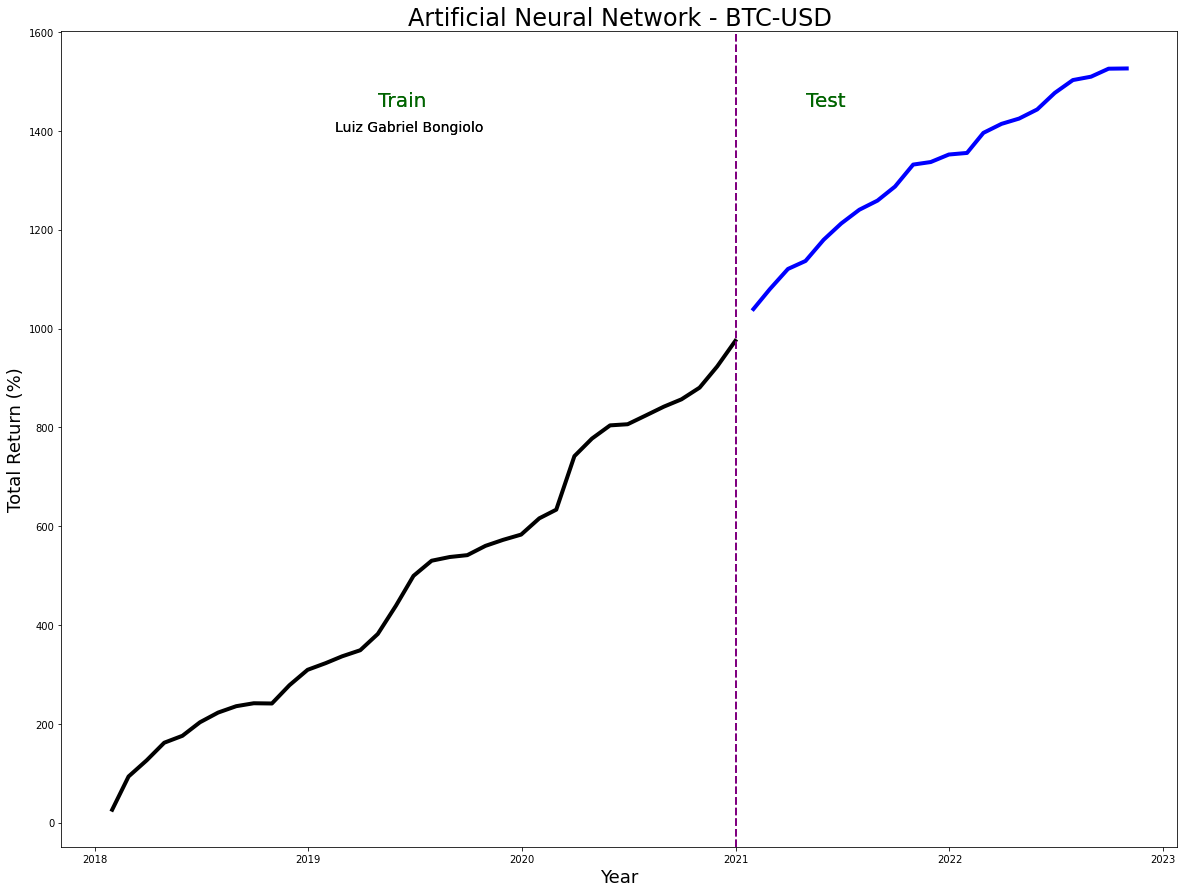

In [117]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plota o grafico
fig, ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Model_return_Accumulated, c=color, linewidth=lw)
    plt.xlabel("Year"
           , fontsize = 18);
    plt.ylabel("Total Return (%)"
           , fontsize = 18);
    plt.title("Artificial Neural Network - "+ str(ticker) , fontsize = 24)
    plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)
    setup = dict(size = 20, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    plt.text("2019-05-01", 1450, "Train " , **setup)
    plt.text("2021-05-01", 1450, "Test ", **setup)
    #plt.text("2015-01-01", 6800, "Retorno total: +587%", **setup2)
    #plt.text("2015-01-01", 6800, "Retorno teste: +218%", **setup2)
    plt.text("2019-02-15", 1400, "Luiz Gabriel Bongiolo", **setup2)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)


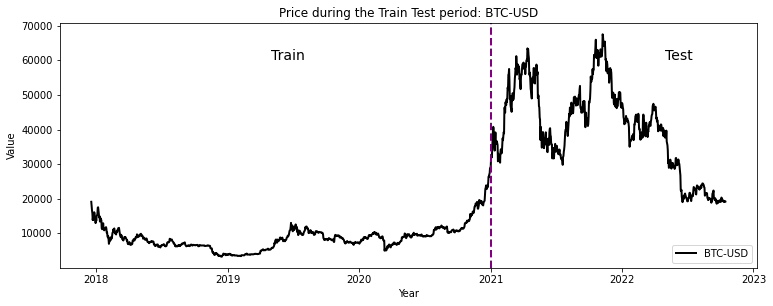

In [118]:
from pandas.plotting import register_matplotlib_converters        #This will fix: ConversionError: Failed to convert value(s) to axis units: '2022-05-01'
register_matplotlib_converters()

# Plotting the real asset price history

plt.figure(figsize=(12.5,4.5))
plt.plot(df1["Close"], label = ticker, linewidth = 2, color = "black")
plt.title("Price during the Train Test period: "+str(ticker))
plt.xlabel("Year")
plt.ylabel("Value")
plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)
plt.legend(loc = "lower right")
setup = dict(size = 14, color = "black")
plt.text("2019-05-01", 60000, "Train " , **setup)
plt.text("2022-05-01", 60000, "Test ", **setup)
plt.show()

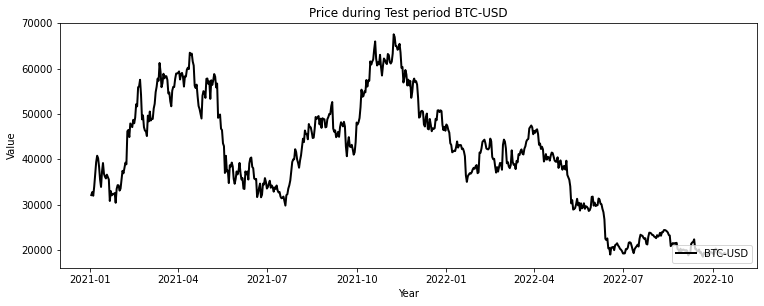

In [119]:
# Plotting the real asset price during the test time interval 

plt.figure(figsize=(12.5,4.5))
plt.plot(df1_test1["Close"], label = ticker, linewidth = 2, color = "black")
plt.title("Price during Test period "+ str(ticker))
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend(loc = "lower right")
plt.show()

In [120]:
# Calculating the performance for the test

df1_test1.loc[: , "Predicted"] = y_pred_test1
df1_test1.loc[: , "Model_return"] = df1_test1.loc[: , "Predicted"]*df1_test1["Target1"]

#Adding a Stop Loss of X% to the math

stop = 0.01
df1_test1.loc[: , "Model_return"] = np.where(df1_test1.loc[: , 'Model_return'] < -stop       #Stop is not literal, it doesnt consider days when the stop hit and goes in your direction 
                                               , -stop, df1_test1.loc[: , 'Model_return'])

df1_test1.loc[: , "Model_return_accumulated"] = df1_test1["Model_return"].cumsum()

In [121]:
df1_test1.loc[: , "Model_return_accumulated"].tail()

Date
2022-10-10    5.421349
2022-10-11    5.421349
2022-10-12    5.421349
2022-10-13    5.421349
2022-10-14    5.420119
Name: Model_return_accumulated, dtype: float64

In [122]:
#df1_test1.index.name = "Date"
df1_test1.reset_index(inplace = True)

df1_test1["Date"] = pd.to_datetime(df1_test1["Date"])

teste_agregado = df1_test1.resample("M", on = "Date").sum()

teste_agregado.loc[: , "Model_return_accumulated"] = teste_agregado["Model_return"].cumsum()*100

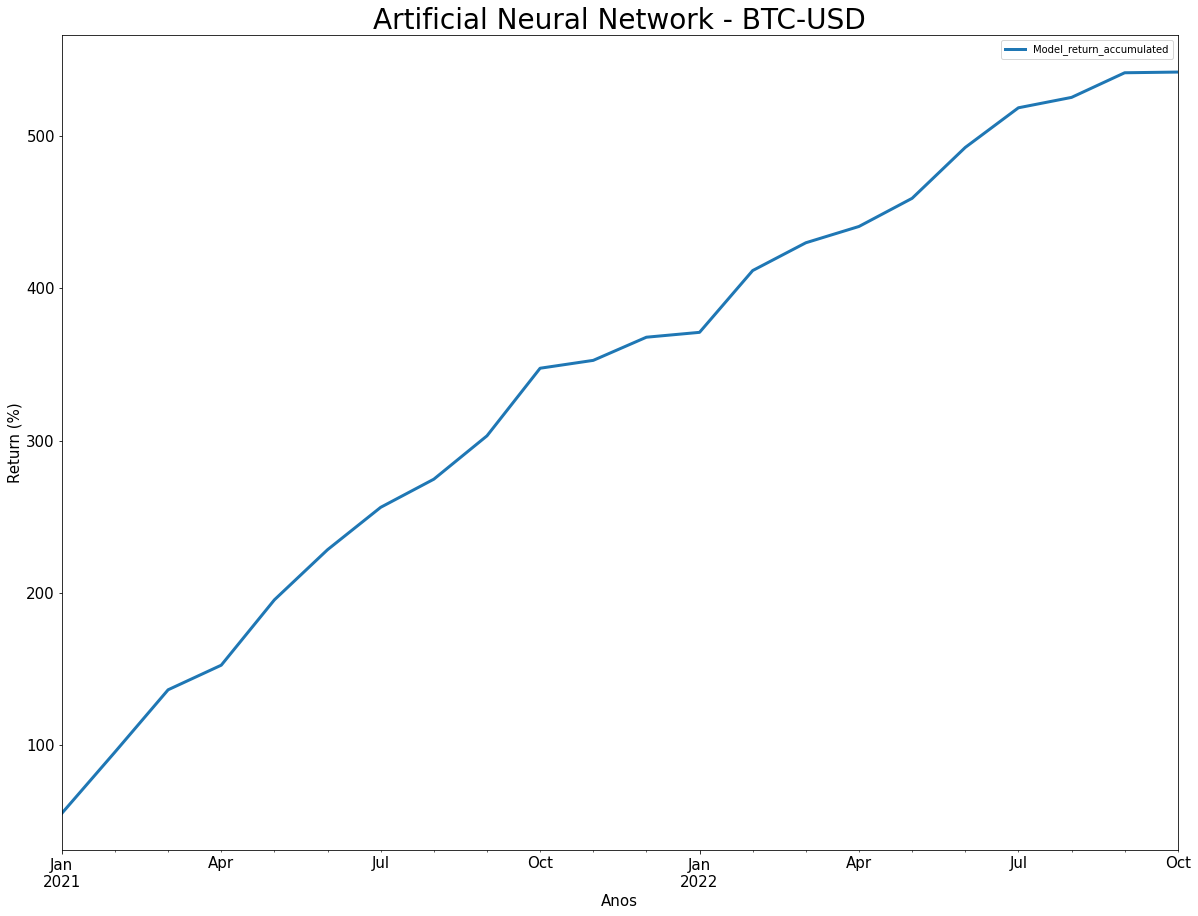

In [123]:
teste_agregado["Model_return_accumulated"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
plt.xlabel("Anos"
           , fontsize = 15);
plt.ylabel("Return (%)"
           , fontsize = 15);
plt.title("Artificial Neural Network - "+str(ticker), fontsize = 28)
plt.legend()
plt.show()

In [124]:
summary = df1_filtered.copy()
summary["Date"] = pd.to_datetime(summary["Date"], format = "%Y-%m")

summary = summary.groupby([summary["Date"].dt.year]).agg({"Model_return": sum})

summary.index = summary.index.set_names(["Ano"])

summary*100

,Model_return
Ano,
2018,309.271688
2019,273.693245
2020,391.934578
2021,377.216220
2022,174.168298


In [125]:
summary_mes = df1_filtered.copy()
summary_mes["Date"] = pd.to_datetime(summary_mes["Date"], format = "%Y-%m")

summary_mes = summary_mes.groupby([summary_mes["Date"].dt.year, summary_mes["Date"].dt.month]).agg({"Model_return": sum})

summary_mes.index = summary_mes.index.set_names(["Year", "Month"])

summary_mes*100

#summary_mes.tail(50)

Model_return
Year Month              
2018 1         26.089878
     2         67.284875
     3         32.748173
     4         35.610301
     5         13.967335
     6         27.367787
     7         19.644196
     8         12.934229
     9          5.955200
     10        -0.487237
     11        37.014984
     12        31.141967
2019 1         13.545246
     2         13.750608
     3         12.333301
     4         32.938554
     5         57.210515
     6         60.352425
     7         30.641543
     8          7.520827
     9          3.774788
     10        18.782428
     11        12.120058
     12        10.722950
2020 1         32.857777
     2         17.574953
     3        108.268633
     4         35.576506
     5         26.730972
     6          2.287462
     7         17.725321
     8         17.915242
     9         14.776721
     10        23.663793
     11        42.811096
     12        51.746102
2021 1         64.473478
     2         40.265083
     3         40.888729
     4         16.158306
     5         42.921211
     6         32.932507
     7         27.839381
     8         18.481581
     9         28.468129
     10        44.415324
     11         5.166120
     12        15.206371
2022 1          3.201840
     2         40.591126
     3         18.244988
     4         10.705672
     5         18.497169
     6         33.415228
     7         26.044318
     8          6.832463
     9         16.177270
     10         0.458225

In [126]:
print("--- BONGIOLO: Artificial Neural Network Results for: " + str(ticker) +" - ("+ str(start) + " - Today) ---")
print("")
print("Train: " + str(start_train)+" - "+str(end_train))
print("Test: " + str(start_test) +" - Today" )
print("Stop: "+ str(stop*100)+"%" + " - Operational cost not included")
print("---------------------------------------------------")
print("")
print("Worst Monthly Return:     {} %".format(round(summary_mes["Model_return"].min(), 3)*100))
print("Best Monthly Return:       {} %".format(int(round(summary_mes["Model_return"].max(), 3)*100)))  #remove int to precise results 
print("Monthly Average Return:    {} %".format(round(summary_mes["Model_return"].mean(), 2)*100))
print("---------------------------------")
print("Worst Annual Return:      {} %".format(round(summary["Model_return"].min(), 3)*100))
print("Best Annual Return:        {} %".format(round(summary["Model_return"].max(), 3)*100))
print("Annual Average Return:     {} %".format(int(round(summary["Model_return"].mean(), 2)*100)))
print("---------------------------------")
print("# Negative Years:        {}".format((summary["Model_return"] < 0).sum()))
print("# Positive Years :       {}".format((summary["Model_return"] > 0).sum()))
print("---------------------------------")
print("# Negative Months :      {}".format((summary_mes["Model_return"] < 0).sum()))
print("# Positive Months:       {}".format((summary_mes["Model_return"] > 0).sum()))
print("---------------------------------")
print("# Total P/L (simple):   {} %".format(int(round(summary_mes["Model_return"].sum(), 3)*100)))
print("# Test  P/L (simple):   {} %".format(int(round(teste_agregado["Model_return"].sum(), 3)*100)))


--- BONGIOLO: Artificial Neural Network Results for: BTC-USD - (2017-12-18 - Today) ---

Train: 2017-12-18 - 2021-1-01
Test: 2021-01-02 - Today
Stop: 1.0% - Operational cost not included
---------------------------------------------------

Worst Monthly Return:     -0.5 %
Best Monthly Return:       108 %
Monthly Average Return:    26.0 %
---------------------------------
Worst Annual Return:      174.2 %
Best Annual Return:        391.9 %
Annual Average Return:     305 %
---------------------------------
# Negative Years:        0
# Positive Years :       5
---------------------------------
# Negative Months :      1
# Positive Months:       57
---------------------------------
# Total P/L (simple):   1526 %
# Test  P/L (simple):   542 %
